## Stage I: Image Collection via Web Scraping

In the first stage of the project, the goal was to collect images from websites, with a special focus on identifying images that could correspond to company logos.

In [1]:
import os
import warnings
from io import BytesIO
from urllib.parse import urljoin

import requests
import urllib3
from bs4 import BeautifulSoup
from PIL import Image, UnidentifiedImageError
import pandas as pd

In [2]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
warnings.simplefilter("ignore", UserWarning)

dataset_path = './dataset/'

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    print(f"The folder '{dataset_path}' has been created.")
else:
    print(f"The folder '{dataset_path}' already exists.")

with open("logs.txt", "a") as logs_file:
    pass

df = pd.read_parquet("logos.snappy.parquet", engine="pyarrow")
domains = df['domain']
print(f"Domain has size {domains.size}.")
print(domains.head())


The folder './dataset/' already exists.
Domain has size 4384.
0                        stanbicbank.co.zw
1                           astrazeneca.ua
2              autosecuritas-ct-seysses.fr
3                                   ovb.ro
4    mazda-autohaus-hellwig-hoyerswerda.de
Name: domain, dtype: object


The `get_logo_from_html(domain)` function was used to extract images from the webpages of the specified domains.

### 1. Accessing URLs
The function attempts to access multiple variations of URLs for each domain to ensure that a functional URL is found:
- `https://www.{domain}`
- `http://www.{domain}`
- `https://{domain}`
- `http://{domain}`

### 2. Searching for Relevant Images
After obtaining the HTML page, the function uses **BeautifulSoup** to parse the content and search for all `<img>` tags, which contain the sources of the images. In this way, all images from the website are obtained. However, since not all images are automatically logos, a filter is applied based on the following conditions to save only the images that appear to be logos:

- **Searching within the `<header>` tag**:
  - If the image is found within a `<header>` tag, which is often used for visible sections of websites (where logos are typically located), and if the image's `alt` attribute contains the word "logo" or if the image file name contains the words "logo" or "favicon," the image is considered relevant.

- **`<link>` tags with `rel='icon'` or `rel='shortcut icon'` attributes**:
  - These tags are used to specify the site favicons, which are usually logos. These images are also added to the list of relevant images.

- **Manually adding `/favicon.ico`**:
  - By default, `/favicon.ico` is added to the list of images, as this is the standard location for favicons used by many sites.

- **Checking Image Dimensions**:
  - It is required that the dimensions of these images be smaller than 512px in both width and height, as logos typically have smaller dimensions.

### 3. Saving Images to the Dataset
Finally, only the images from the website that meet the conditions listed above are saved to the dataset.

In [3]:
def save_image(url, file_name, dataset_path):
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.5615.49 Safari/537.36 Edge/112.0.1722.64',
            'Accept-Language': 'en-US,en;q=0.5',
        }

        try:
            response = requests.get(url, headers=headers, timeout=10, verify=False)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            if 'favicon.ico' not in url:
                with open("logs.txt", "a") as logs_file:
                    logs_file.write(f"Error accessing {url}: {e}\n")
            return None

        content_type = response.headers.get('Content-Type', '')
        valid_types = ['image/png', 'image/jpeg', 'image/jpg', 'image/webp', 'image/gif', 'image/x-icon', 'image/vnd.microsoft.icon']
        if content_type not in valid_types:
            return None

        image_data = BytesIO(response.content)
        try:
            image = Image.open(image_data)
            image.verify()
            image = Image.open(image_data)
        except UnidentifiedImageError:
            return None

        width, height = image.size
        if width > 512 or height > 512:
            return None

        image = image.convert("RGBA")
        file_path = os.path.join(dataset_path, file_name + ".png")
        image.save(file_path, format="PNG")

    except Exception as e:
        with open("logs.txt", "a") as logs_file:
            logs_file.write(f"Error downloading the image from {url}: {e}\n")

In [4]:
def get_logo_from_html(domain):
    response = None
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.5615.49 Safari/537.36 Edge/112.0.1722.64',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept': 'image/x-icon, image/*;q=0.8, */*;q=0.5'
        }

        urls = [
            f'https://www.{domain}',
            f'http://www.{domain}',
            f'https://{domain}',
            f'http://{domain}'
        ]

        correctUrl = ''
        for url in urls:
            headers['Referer'] = url
            response = requests.get(url, verify=False, headers=headers, timeout=10)
                    
            if response.status_code == 403:
                correctUrl = url
                break

            response.raise_for_status()
            correctUrl = url
            break

        if response is None:
            with open("logs.txt", "a") as logs_file:
                logs_file.write(f"All requests failed for {domain}\n")
            return None, []

        try:
            soup = BeautifulSoup(response.text, 'html.parser')

            found_images = []
            images = soup.find_all('img')
            for image in images:
                image_url = image.get('src')
                alt_text = image.get('alt', '').lower()
                file_name = os.path.basename(image_url) if image_url else ''

                if image.find_parent('header') and (
                    'logo' in alt_text or 
                    'logo' in file_name.lower() or 
                    'favicon' in file_name.lower()
                ):
                    found_images.append(image_url)

            link_tags = soup.find_all('link', rel='icon') + soup.find_all('link', rel='shortcut icon')
            for link in link_tags:
                found_images.append(link.get('href'))
            
            found_images.append('/favicon.ico')
            
            found_images = list(set(filter(None, found_images)))
            return correctUrl, found_images
        
        except Exception as e:
            with open("logs.txt", "a") as logs_file:
                logs_file.write(f"Parsing error for {domain}: {e}\n")
            return None, []
    except Exception as e:
        with open("logs.txt", "a") as logs_file:
            logs_file.write(f"Error processing domain {domain}: {e}\n")
        return None, []

The process was repeated for each domain in the dataset to collect as many images that appeared to be logos as possible.

In [ ]:
def scrape_from_domains(domains):
    size = len(domains)

    print(f"Starting to process {size} domains...")

    for i, domain in enumerate(domains):
        file_name = domain + '_' + str(i)

        if i % 100 == 0:
            image_count = sum([len(files) for r, d, files in os.walk(dataset_path)])
            print(f"Processing {i + 1}/{size} domains. Current image count in dataset: {image_count}")

        try:
            url, logo_urls = get_logo_from_html(domain)
            
            for j, logo_url in enumerate(logo_urls):
                logo_url = urljoin(url, logo_url)
                save_image(logo_url, f"{file_name}_{j}", dataset_path)
        except Exception as e:
            with open("logs.txt", "a") as logs_file:
                logs_file.write(f"Error processing domain {domain}: {e}\n")

    print("Processing complete. All domains have been processed.")

scrape_from_domains(domains)

### stage 2


In [5]:
import random
import textwrap

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import InterpolationMode
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [6]:
class LogosDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder, self.image_files[idx])
        
        image = Image.open(image_path).convert('RGBA')
        
        r, g, b, a = image.split()
        
        image = Image.merge("RGB", (r, g, b))
        black_background = Image.new("RGB", image.size, (0, 0, 0))
        image = Image.composite(image, black_background, a)
        
        if self.transform:
            image = self.transform(image)

        return image, self.image_files[idx]

In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomPerspective(distortion_scale=0.5, p=1.0, interpolation=InterpolationMode.BICUBIC),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

dataset = LogosDataset(image_folder=dataset_path, transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

batches = list(dataloader)
print(f"There are {len(batches)} batches of size {batches[0][0].size()}, with a total of {len(dataset)} images.")

There are 43 batches of size torch.Size([32, 3, 256, 256]), with a total of 1360 images.


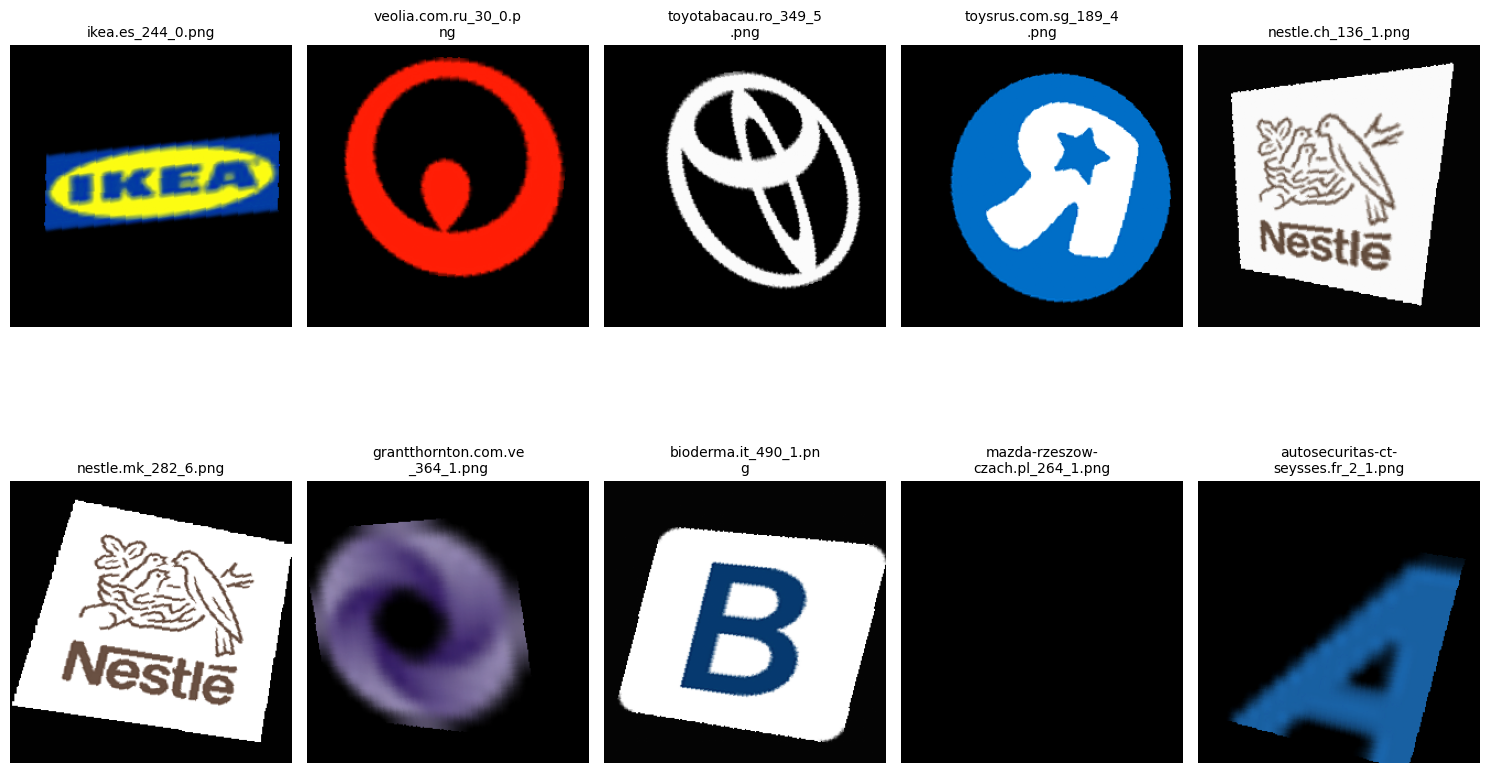

In [8]:
def show_images(dataset, num_images=10, max_title_length=20):
    num_columns = 5
    num_rows = 2
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))
    axes = axes.flatten()
    indices = random.sample(range(len(dataset)), num_images)
    
    for ax, idx in zip(axes, indices):
        image, file_name = dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        image = (image * 0.5) + 0.5
        ax.imshow(image)
        ax.axis("off")
        
        wrapped_title = textwrap.fill(file_name, width=max_title_length)
        ax.set_title(wrapped_title, fontsize=10)
    
    plt.tight_layout()
    plt.show()

show_images(dataset)

In [ ]:
def extract_features(model, dataloader, device):
    model.eval()
    features = []
    image_names = []

    with torch.no_grad():
        for images, names in dataloader:
            images = images.to(device)

            if isinstance(model, models.ResNet):
                x = model.conv1(images)
                x = model.bn1(x)
                x = model.relu(x)
                x = model.maxpool(x)
                x = model.layer1(x)
                x = model.layer2(x)
                x = model.layer3(x)
                x = model.layer4(x)
                x = model.avgpool(x)
                outputs = x.view(x.size(0), -1)

            features.append(outputs.cpu().numpy())
            image_names.extend(names)

    features = np.vstack(features)
    print(f"{model.__class__.__name__}: {features.shape[0]} images with {features.shape[1]} features\n")
    
    print(f"Mean: {np.mean(features, axis=0)}")
    print(f"Standard deviation: {np.std(features, axis=0)}")
    print(f"Min: {np.min(features, axis=0)}")
    print(f"Max: {np.max(features, axis=0)}\n")

    print(f"{features[:5]}\n")

    images, _= next(iter(dataloader))
    fig, axes = plt.subplots(2, 5, figsize=(12, 8))
    for i in range(5):
        axes[0, i].hist(features[:, i], bins=50)
        axes[0, i].set_title(f"Feature {i+1}")
        axes[0, i].set_xlabel("Value")
        axes[0, i].set_ylabel("Frequency")

        image = images[i].cpu().permute(1, 2, 0).numpy()
        image = (image * 0.5) + 0.5

        axes[1, i].imshow(image)
        axes[1, i].axis("off")
    plt.tight_layout()
    plt.show()

    return features, image_names

Using device: cuda
GPU: NVIDIA GeForce GTX 1650

ResNet: 1360 images with 2048 features

Mean: [0.21793677 0.971333   0.07087651 ... 0.11119006 0.08384652 0.34794578]
Standard deviation: [0.15744841 0.70512253 0.0911358  ... 0.11320458 0.14409722 0.26953253]
Min: [0.01332166 0.00109478 0.0011818  ... 0.         0.         0.00499442]
Max: [1.0403912  3.3906796  0.68015707 ... 0.7367428  1.1034616  1.4944413 ]

[[0.1099956  1.6418682  0.0479484  ... 0.12195752 0.00929951 0.12553203]
 [0.51180506 0.1484992  0.4888396  ... 0.1288416  0.03846536 0.6535455 ]
 [0.20691048 0.14529084 0.02720186 ... 0.14159402 0.01237697 0.49759638]
 [0.06167901 1.8844781  0.02980977 ... 0.05926627 0.         0.12073156]
 [0.14311059 1.3680954  0.00894336 ... 0.00294246 0.00697945 0.0376993 ]]



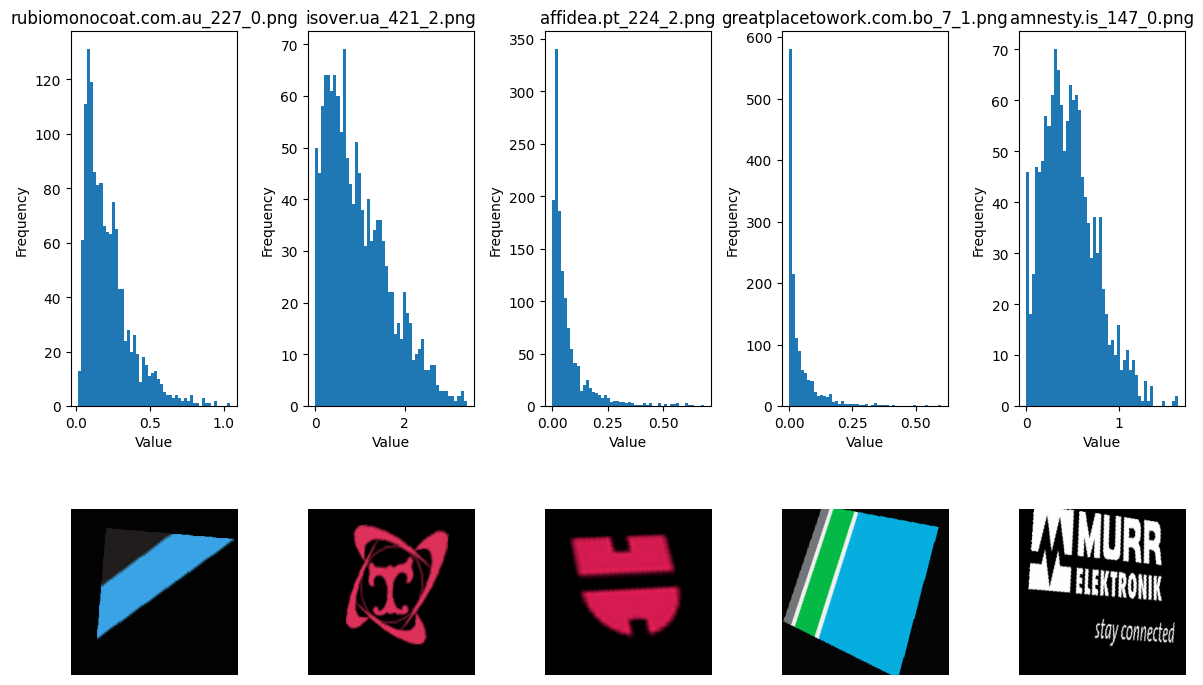

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}\n")


all_models = {
    'ResNet50': models.resnet50(pretrained=True).to(device),
}

all_features = {}

for model_name, model in all_models.items():
    features, names = extract_features(model, dataloader, device)
    
    all_features[model_name] = {
        'features': features,
        'names': names
    }

In [11]:
def clustering(features, eps=0.7, min_samples=1):
    clustering = DBSCAN(eps=eps, min_samples=min_samples)
    labels = clustering.fit_predict(features)

    return labels